# Show new bathy improvement
## comparison of "single" to "double"

In [173]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import xarray as xr

In [192]:
maxday = 30
year = 2017

In [193]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    temp1['DateTime'] = pd.to_datetime(temp1["dtUTC"], format="%Y-%m-%d %H:%M:%S")
    temp1['Month'] = temp1['DateTime'].dt.month
    temp1['Day'] = temp1['DateTime'].dt.day
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [194]:
def cleanup_ferry(temp3):
    return temp3[((temp3.SA > 0.2) | (temp3.mod_vosaline - temp3.SA < 20)) & ((temp3.Lon > -123.8) | (temp3.SA > 14))]

In [195]:
pieces = (
         ['/data/sallen/results/MEOPAR/202111/ObsModel//ObsModel_single_ferry_20170101_20171231.csv']
         )

In [196]:
temp2 = read_pieces(pieces)
temp2['SA'] = temp2['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)
temp2 = cleanup_ferry(temp2)

temp2c = temp2[(temp2.Month == 7) & (temp2.Day <= maxday)]

In [197]:
def make_a_double(suffix):
    pieces2 = []
    for day in range(1, min(maxday+1, 30)):
        pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double{suffix}ferry_{year}06{day:02d}_{year}06{day+1:02d}.csv')
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double{suffix}ferry_{year}0630_{year}0701.csv')
    temp3 = read_pieces(pieces2)
    temp3['SA'] = temp3['salinity (g/kg)']
    temp3.drop(columns='Unnamed: 0', inplace=True)
    temp3.drop_duplicates(inplace=True)
    temp3 = cleanup_ferry(temp3)
    return temp3

In [198]:
temp3 = make_a_double('_')

In [199]:
temp1 = make_a_double('_p75_')

In [200]:
temp125 = make_a_double('_1p25_')

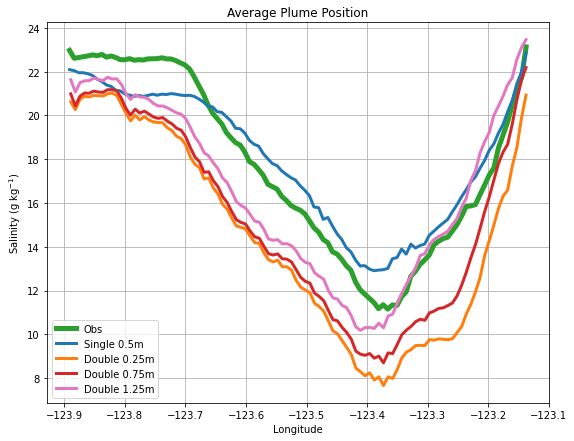

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2c.Lon, temp2c.SA, 'mean', bins=100)
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), bin_means, c='tab:green', lw=5,
               label='Obs');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp2c.Lon, temp2c.mod_vosaline, 'mean', bins=100)
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), bin_means, c='tab:blue', lw=3,
               label='Single 0.5m');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp3.Lon, temp3.mod_vosaline, 'mean', bins=100)
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), bin_means, c='tab:orange', lw=3,
               label='Double 0.25m');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp1.Lon, temp1.mod_vosaline, 'mean', bins=100)
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), bin_means, c='tab:red', lw=3,
               label='Double 0.75m');
bin_means, bin_edges, binnumber = stats.binned_statistic(temp125.Lon, temp125.mod_vosaline, 'mean', bins=100)
plt.plot(0.5*(bin_edges[:-1]+bin_edges[1:]), bin_means, c='tab:pink', lw=3,
               label='Double 1.25m');

ax.set_xlabel('Longitude')
ax.set_ylabel('Salinity (g kg$^{-1}$)')
ax.set_title('Average Plume Position')
plt.grid();
plt.legend(loc='lower left');